In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import string
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
%config Completer.use_jedi = False

In [2]:
def plot_progress(train_losses, train_accs, test_loss, test_accs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_accs, label='train accuracy')
    ax2.plot(test_accs, label='test accuracy')
    ax2.plot(np.ones_like(accs), '--', label='100% accuracy')
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()
    
    

In [3]:
data = pd.read_csv('vins_train.csv')
data.head()

,VIN,CarBrand,CarModel,YearManufactured,EngineType,EngineVolume,Color
0,NVKZTHZ0X18TM05845,ВАЗ (LADA),2115 Samara,2009,Бензин,1.6,Серый
1,HNVKZXWFJ22J206195,ВАЗ (LADA),2112,2003,Бензин,1.6,Чёрный
2,HYQS2DXM922I900038,ВАЗ (LADA),21099,2003,Бензин,1.4,Серебряный
3,HNVKZF1KZ636X08104,ВАЗ (LADA),2110,1998,Бензин,1.6,Зелёный
4,EBLI88GR11J203825,Opel,Meriva,2008,Бензин,1.6,Чёрный


In [4]:
max_vin_length = max(data['VIN'].apply(lambda x: len(x)))
data['VIN'] = data['VIN'].apply(lambda x: x.ljust(max_vin_length, '-'))

In [5]:
data.head()

,VIN,CarBrand,CarModel,YearManufactured,EngineType,EngineVolume,Color
0,NVKZTHZ0X18TM05845--,ВАЗ (LADA),2115 Samara,2009,Бензин,1.6,Серый
1,HNVKZXWFJ22J206195--,ВАЗ (LADA),2112,2003,Бензин,1.6,Чёрный
2,HYQS2DXM922I900038--,ВАЗ (LADA),21099,2003,Бензин,1.4,Серебряный
3,HNVKZF1KZ636X08104--,ВАЗ (LADA),2110,1998,Бензин,1.6,Зелёный
4,EBLI88GR11J203825---,Opel,Meriva,2008,Бензин,1.6,Чёрный


In [6]:
data.shape

(338921, 7)

In [7]:
tokens = set(''.join(data['VIN']))
car_brands = set(data['CarBrand'])
car_models = set(data['CarModel'])
colors = set(data['Color'])
n_tokens = len(tokens)
token_index_map = {l: i for i, l in enumerate(tokens)}
car_brands_index_map = {l: i for i, l in enumerate(car_brands)}
car_models_index_map = {l: i for i, l in enumerate(car_models)}
colors_index_map = {l: i for i, l in enumerate(colors)}

In [8]:
print(car_brands_index_map)
print(car_models_index_map)
print(colors_index_map)

{'Skoda': 0, 'ВАЗ (LADA)': 1, 'Opel': 2, 'Mazda': 3}
{'CX-3': 0, 'Bongo Friendee': 1, 'Favorit': 2, 'Revue': 3, 'Zafira': 4, 'BT-50': 5, 'MPV': 6, 'Millenia': 7, 'Octavia': 8, 'Corsa': 9, 'Rapid': 10, 'Vivaro': 11, '2113 Samara': 12, 'Ascona': 13, 'Felicia': 14, '323': 15, 'Carol': 16, 'Insignia': 17, 'Fabia Scout': 18, 'Xedos 9': 19, 'Sentia': 20, 'AZ-Wagon': 21, 'Octavia Scout': 22, 'CX-7': 23, 'Bongo Brawny': 24, '21099': 25, 'RX-8': 26, 'Campo': 27, '1300': 28, '1111 Ока': 29, 'Kalina': 30, 'MX-5': 31, '2131 (4x4) Рысь': 32, 'Insignia OPC': 33, 'XRAY': 34, 'Octavia RS': 35, '2328': 36, '3': 37, 'Superb': 38, 'Fabia': 39, 'Astra': 40, 'Fabia RS': 41, 'Clef': 42, 'Astra GTC': 43, 'Tribute': 44, 'Verisa': 45, '2114 Samara': 46, '2103': 47, '2101': 48, '2129': 49, 'Combo': 50, 'MX-6': 51, '2110': 52, '2121 (4x4) Фора': 53, 'Vectra OPC': 54, 'Eunos': 55, 'Antara': 56, 'El Lada': 57, 'Largus': 58, 'Frontera': 59, 'Levante': 60, 'Efini': 61, 'Astra OPC': 62, 'Granta': 63, 'Astra Family': 

In [9]:
len(car_brands_index_map)

4

In [10]:
len(tokens)

37

In [11]:
class VinDataset(Dataset):
    
    def __init__(self, lines, labels):
        self.lines = lines  # объекты
        self.labels = labels  # ответы
        
    def __len__(self):
        return len(self.lines)  # количество объектов
    
    def __getitem__(self, idx):
        x = self.line_to_tensor(self.lines[idx]).long()  # преобразуем один объект в тензор индексов, тип long()
        y = torch.tensor([
            car_brands_index_map[self.labels[idx][0]], 
            car_models_index_map[self.labels[idx][1]],
            colors_index_map[self.labels[idx][2]]
        ]).float()  # ответы на объекте, тип float()
        return x, y
    
    @staticmethod
    def line_to_tensor(line):
        return torch.tensor([token_index_map[l] for l in line])

In [12]:
d =data[['CarBrand', 'CarModel']].values
d[0]

array(['ВАЗ (LADA)', '2115 Samara'], dtype=object)

In [13]:
vin_dataset = VinDataset(lines=data['VIN'].values, labels=data[['CarBrand', 'CarModel', 'Color']].values)
vin_dataset[0]

(tensor([19,  8, 13, 23,  6, 22, 23, 20, 32, 24, 34,  6,  2, 20, 15, 34, 10, 15,
         31, 31]),
 tensor([ 1., 82., 13.]))

In [14]:
one_objext_batch_dataloader = DataLoader(vin_dataset, batch_size=1, shuffle=True)
x, y = next(iter(one_objext_batch_dataloader))
print(x.shape)
emb_layer = nn.Embedding(num_embeddings=len(token_index_map) + 1, embedding_dim=8,)
emb_output = emb_layer(x)
emb_output.shape

torch.Size([1, 20])


torch.Size([1, 20, 8])

In [15]:
x

tensor([[ 7, 11, 22,  6, 28,  8,  8,  6, 15, 20,  5, 16, 20, 15, 15, 10, 34, 31,
         31, 31]])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data['VIN'], data[['CarBrand', 'CarModel', 'Color']], test_size=0.05, 
)

train_dataset = VinDataset(lines=X_train.values, labels=y_train[['CarBrand', 'CarModel', 'Color']].values)
test_dataset = VinDataset(lines=X_test.values, labels=y_test[['CarBrand', 'CarModel', 'Color']].values)

train_vin_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_vin_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=True)

In [19]:
class VinCNN(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, kernel_size=1, embedding_dim=16):
        super(VinCNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.cnn = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=hidden_size,
            kernel_size=kernel_size,
            padding='same',
        )
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(num_features=hidden_size)
        self.dropout = nn.Dropout(0.6)
        self.linear_car_brands = nn.Linear(hidden_size, len(car_brands_index_map))
        self.linear_car_models = nn.Linear(hidden_size, len(car_models_index_map))
        self.linear_colors = nn.Linear(hidden_size, len(colors_index_map))
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        x = self.embedding(x) # формируем слой эмбедингов (посимвольно)
        x = self.cnn(x.permute(0, 2, 1)) # применяем одномерную свертку
        x, _ = x.max(dim=-1) # применяем max-pooling
        x = self.relu(x) # применяем функцию активации ReLU
        x = self.batchnorm(x) # проводим нормализацию
        x = self.dropout(x) # проводим регуляризацию
        # Формируем выходы (используем softmax, т.к. решаем задачу многоклассовой классификации)
        x_car_brands = self.linear_car_brands(x)
        x_car_models = self.linear_car_models(x)
        x_colors = self.linear_colors(x)
        x_car_brands = self.softmax(x_car_brands).squeeze() 
        x_car_models = self.softmax(x_car_models).squeeze()
        x_colors = self.softmax(x_colors).squeeze()
        return x_car_brands, x_car_models, x_colors # 3 многоклассовых выхода

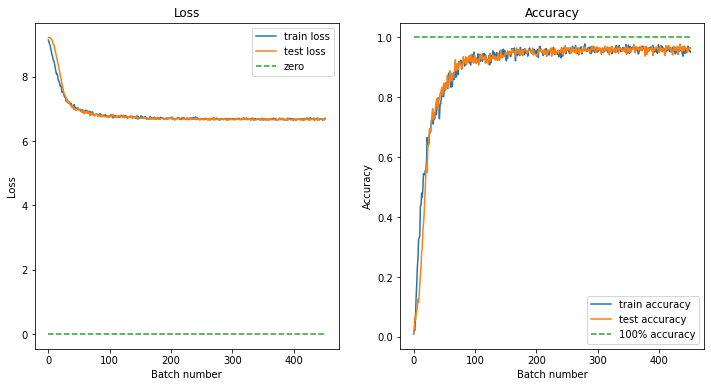

KeyboardInterrupt: 

In [21]:
# Инициализируем модель
model = VinCNN(
    vocab_size=len(token_index_map),
    hidden_size=2048,
    kernel_size=16,
)
# Определяем метод оптимизации
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Создаем для каждого из параметров свою функцию потерь 
# (используем кросс-энтропию, т.к. решаем задачу многоклассовой классификации)
brand_head_loss_fn = nn.CrossEntropyLoss()
model_head_loss_fn = nn.CrossEntropyLoss()
color_head_loss_fn = nn.CrossEntropyLoss()

n_epochs = 5

losses = []
accs = []

test_losses = []
test_accs = []

# Обучаем сеть
for i in range(n_epochs):
    for x_train, y_train in train_vin_dataloader:
        model.train() # переводим модель в режим обучения (для расчета градиентов)
        
        brand_pred, model_pred, color_pred = model(x_train)
        
        brand_head_loss = brand_head_loss_fn(brand_pred, y_train[:, 0].long())
        model_head_loss = model_head_loss_fn(model_pred, y_train[:, 1].long())
        color_head_loss = color_head_loss_fn(color_pred, y_train[:, 2].long())
        # Суммируем потери, чтобы учитывать ошибки по каждому из 3 параметров
        train_total_loss = brand_head_loss + model_head_loss + color_head_loss
        
        # Подсчитываем метрику (минимальная Accuracy по 3 параметрам) 
        train_brand_acc = (torch.argmax(brand_pred, dim=1) == y_train[:, 0].int()).float().mean()
        train_model_acc = (torch.argmax(model_pred, dim=1) == y_train[:, 1].int()).float().mean()
        train_color_acc = (torch.argmax(color_pred, dim=1) == y_train[:, 2].int()).float().mean()
        train_total_acc = min([train_brand_acc, train_model_acc, train_color_acc])
        
        optimizer.zero_grad() # обнуляем градиенты с прошлого шага
        train_total_loss.backward() # расчитываем градиенты на текущем шаге
        optimizer.step() # обновляем веса
        
        model.eval() # переводим  модель в режим оценивания (чтобы не расчитывать градиенты)

        x_test, y_test = next(iter(test_vin_dataloader))
        
        test_brand_pred, test_model_pred, test_color_pred = model(x_test)
        
        test_brand_head_loss = brand_head_loss_fn(test_brand_pred, y_test[:, 0].long())
        test_model_head_loss = model_head_loss_fn(test_model_pred, y_test[:, 1].long())
        test_color_head_loss = color_head_loss_fn(test_color_pred, y_test[:, 2].long())
        # Суммируем потери, чтобы учитывать ошибки по каждому из 3 параметров
        test_total_loss = test_brand_head_loss + test_model_head_loss + test_color_head_loss
        
        test_brand_acc = (torch.argmax(test_brand_pred, dim=1) == y_test[:, 0].int()).float().mean()
        test_model_acc = (torch.argmax(test_model_pred, dim=1) == y_test[:, 1].int()).float().mean()
        test_color_acc = (torch.argmax(test_color_pred, dim=1) == y_test[:, 2].int()).float().mean()
        # Подсчитываем метрику (минимальная Accuracy по 3 параметрам) 
        test_total_acc = min([test_brand_acc, test_model_acc, test_color_acc])
        
        losses.append(train_total_loss.item())
        accs.append(train_total_acc.item())
        
        test_losses.append(test_total_loss.item())
        test_accs.append(test_total_acc.item())
        
        plot_progress(losses, accs, test_losses, test_accs)

In [22]:
def get_test_accuraccy(model, dataloader):
    test_accs = []

    for x_test, y_test in dataloader:
        test_brand_pred, test_model_pred, test_color_pred = model(x_test)
        
        test_brand_acc = (torch.argmax(test_brand_pred, dim=1) == y_test[:, 0].int()).float().mean()
        test_model_acc = (torch.argmax(test_model_pred, dim=1) == y_test[:, 1].int()).float().mean()
        test_color_acc = (torch.argmax(test_color_pred, dim=1) == y_test[:, 2].int()).float().mean()
        test_total_acc = min([test_brand_acc, test_model_acc, test_color_acc]).numpy()
        test_accs.extend(test_total_acc.reshape(-1, 1))

    return np.mean(test_accs)

In [23]:
get_test_accuraccy(model, test_vin_dataloader)

0.96127546

In [144]:
class VinLSTM(nn.Module):
    
    def __init__(self, vocab_size, hidden_size, embedding_dim=16):
        super(VinLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)
        #self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(num_features=hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.linear_car_brands = nn.Linear(hidden_size, len(car_brands_index_map))
        self.linear_car_models = nn.Linear(hidden_size, len(car_models_index_map))
        self.linear_colors = nn.Linear(hidden_size, len(colors_index_map))
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        #x = self.relu(x)
        #x = self.batchnorm(x[:, -1, :])
        x = self.dropout(x)
        #print(x)
        #print(x[0])
        x_car_brands = self.linear_car_brands(x[:, -1, :])
        x_car_models = self.linear_car_models(x[:, -1, :])
        x_colors = self.linear_colors(x[:, -1, :])
        x_car_brands = self.softmax(x_car_brands).squeeze()
        x_car_models = self.softmax(x_car_models).squeeze()
        x_colors = self.softmax(x_colors).squeeze()
        return x_car_brands, x_car_models, x_colors

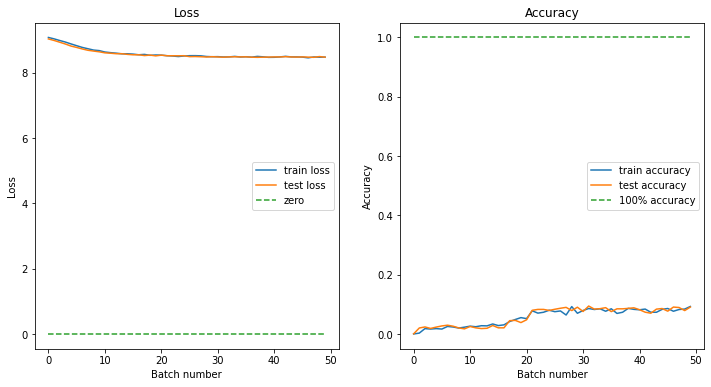

In [ ]:
model = VinLSTM(
    vocab_size=len(token_index_map),
    hidden_size=16,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
brand_head_loss_fn = nn.CrossEntropyLoss()
model_head_loss_fn = nn.CrossEntropyLoss()
color_head_loss_fn = nn.CrossEntropyLoss()

n_epochs = 5

losses = []
accs = []

test_losses = []
test_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_vin_dataloader:

        model.train()
        
        brand_pred, model_pred, color_pred = model(x_train)
        
        brand_head_loss = brand_head_loss_fn(brand_pred, y_train[:, 0].long())
        model_head_loss = model_head_loss_fn(model_pred, y_train[:, 1].long())
        color_head_loss = color_head_loss_fn(color_pred, y_train[:, 2].long())
        train_total_loss = brand_head_loss + model_head_loss + color_head_loss
        
        train_brand_acc = (torch.argmax(brand_pred, dim=1) == y_train[:, 0].int()).float().mean()
        train_model_acc = (torch.argmax(model_pred, dim=1) == y_train[:, 1].int()).float().mean()
        train_color_acc = (torch.argmax(color_pred, dim=1) == y_train[:, 2].int()).float().mean()
        train_total_acc = min([train_brand_acc, train_model_acc, train_color_acc])
        
        optimizer.zero_grad()
        train_total_loss.backward()
        optimizer.step()
        model.eval()

        x_test, y_test = next(iter(test_vin_dataloader))
        
        test_brand_pred, test_model_pred, test_color_pred = model(x_test)
        
        test_brand_head_loss = brand_head_loss_fn(test_brand_pred, y_test[:, 0].long())
        test_model_head_loss = model_head_loss_fn(test_model_pred, y_test[:, 1].long())
        test_color_head_loss = color_head_loss_fn(test_color_pred, y_test[:, 2].long())
        test_total_loss = test_brand_head_loss + test_model_head_loss + test_color_head_loss
        
        test_brand_acc = (torch.argmax(test_brand_pred, dim=1) == y_test[:, 0].int()).float().mean()
        test_model_acc = (torch.argmax(test_model_pred, dim=1) == y_test[:, 1].int()).float().mean()
        test_color_acc = (torch.argmax(test_color_pred, dim=1) == y_test[:, 2].int()).float().mean()
        test_total_acc = min([test_brand_acc, test_model_acc, test_color_acc])
        
        losses.append(train_total_loss.item())
        accs.append(train_total_acc.item())
        
        test_losses.append(test_total_loss.item())
        test_accs.append(test_total_acc.item())
        
        plot_progress(losses, accs, test_losses, test_accs)

# Для Stepik

In [48]:
df_test = pd.read_csv('vins_test.csv')
df_test['VIN'] = df_test['VIN'].apply(lambda x: x.ljust(max_vin_length, '-'))
df_test.head()

,VIN
0,YQSR9TLW9JO00224----
1,3I394K1QKM9H02594---
2,EYQSM78R362WN07506--
3,ENVKZF1KZ097TQ03193-
4,HNVKZAHVI572HFP01935


In [49]:
class VinTestDataset(Dataset):
    
    def __init__(self, lines):
        self.lines = lines  # объекты
        
    def __len__(self):
        return len(self.lines)  # количество объектов
    
    def __getitem__(self, idx):
        x = self.line_to_tensor(self.lines[idx]).long()  # преобразуем один объект в тензор индексов, тип long()
        return x
    
    @staticmethod
    def line_to_tensor(line):
        return torch.tensor([token_index_map[l] for l in line])

In [52]:
test = VinTestDataset(lines=df_test['VIN'].values)

In [81]:
test_brands_ind = []
test_models_ind = []
test_colors_ind = []

for x_test in test_dataloader:
        model.eval()
        
        test_brand_pred, test_model_pred, test_color_pred = model(x_test)
        
        test_brands_batch = torch.argmax(test_brand_pred, dim=1)
        test_models_batch = torch.argmax(test_model_pred, dim=1)
        test_colors_batch = torch.argmax(test_color_pred, dim=1)
        test_brands_ind.extend(test_brands_batch.tolist())
        test_models_ind.extend(test_models_batch.tolist())
        test_colors_ind.extend(test_colors_batch.tolist())
        
test_brands_ind = np.array(test_brands_ind)
test_models_ind = np.array(test_models_ind)
test_colors_ind = np.array(test_colors_ind)

In [96]:
answers = pd.DataFrame([test_brands_ind, test_models_ind, test_colors_ind])
answers = answers.T
answers.columns = ['CarBrand', 'CarModel', 'Color']
answers

,CarBrand,CarModel,Color
0,1,46,13
1,1,99,1
2,1,129,10
3,1,52,2
4,2,25,8
...,...,...,...
19995,1,85,1
19996,1,12,14
19997,1,25,6
19998,2,123,1


In [110]:
answers['CarBrand'] = answers['CarBrand'].apply(lambda x: get_brand(x))
answers['CarModel'] = answers['CarModel'].apply(lambda x: get_model(x))
answers['Color'] = answers['Color'].apply(lambda x: get_color(x))

In [112]:
answers[['CarBrand', 'CarModel', 'Color']].to_csv('submission.csv', index=False)

In [84]:
test_brands_ind.shape

(20000,)

In [87]:
pd.Series(test_brands_ind, test_brands_ind)

1    1
1    1
1    1
1    1
2    2
    ..
1    1
1    1
1    1
2    2
1    1
Length: 20000, dtype: int32

In [92]:
test_brands_ind

array([1, 1, 1, ..., 1, 2, 1])

Серебряный    57979
Белый         51763
Чёрный        43598
Зелёный       38775
Серый         38069
Синий         36808
Красный       29402
Бежевый       11456
Фиолетовый     8385
Голубой        6335
Коричневый     6211
Золотой        3679
Пурпурный      2893
Жёлтый         1924
Оранжевый      1192
Розовый         452
Name: Color, dtype: int64

In [101]:
car_brands_dict

NameError: name 'car_brands_dict' is not defined

In [102]:
colors_index_map

{'Жёлтый': 0,
 'Белый': 1,
 'Бежевый': 2,
 'Синий': 3,
 'Пурпурный': 4,
 'Розовый': 5,
 'Зелёный': 6,
 'Фиолетовый': 7,
 'Чёрный': 8,
 'Коричневый': 9,
 'Красный': 10,
 'Золотой': 11,
 'Оранжевый': 12,
 'Серый': 13,
 'Серебряный': 14,
 'Голубой': 15}

In [105]:
# Функции для получения ключа по значению
def get_brand(val):
    for key, value in car_brands_index_map.items():
         if val == value:
            return key
    return "key doesn't exist"

def get_model(val):
    for key, value in car_models_index_map.items():
         if val == value:
            return key
    return "key doesn't exist"


def get_color(val):
    for key, value in colors_index_map.items():
         if val == value:
            return key
    return "key doesn't exist"
